In [1]:
# https://github.com/stanfordnlp/GloVe
# https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db
# https://github.com/keshavbhandari/Unsupervised-Learning-With-Glove-Word-Embeddings-on-Search-Queries/blob/master/Glove_Clustering.py
# https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db

import os
import json
import numpy as np
import pandas as pd
from scipy import spatial

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import nltk

from nltk.cluster import KMeansClusterer
from gensim.models import KeyedVectors

from sklearn import cluster
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
# defining relative paths
parent_dir = os.path.dirname(os.path.abspath(os.getcwd()))
data_dir = os.path.join(parent_dir, "Data")

In [3]:
eval_df = pd.read_csv(os.path.join(data_dir,"eval_df.csv"))
eval_df["embeddings"] = eval_df.embeddings.apply(json.loads)
#eval_df["embeddings"] = eval_df["embeddings"].apply(lambda x: np.asanyarray(x))

In [22]:
train_df = pd.read_csv(os.path.join(data_dir, 'train_english_cleaned_without_mentions.tsv'), delimiter='\t')
test_df = pd.read_csv(os.path.join(data_dir, 'test_english_cleaned_without_mentions.tsv'), delimiter='\t')

### Importing Glove Embeddings

In [9]:
eval_df["embeddings"][0]

array([-4.95423786e-02, -2.64525890e-01, -6.94699958e-02, -6.89591393e-02,
       -9.71780915e-04,  2.49378145e-01, -1.93493143e-01,  4.36924547e-01,
        5.83349943e-01, -3.56321745e-02,  2.05376565e-01,  2.47899126e-02,
       -1.11255579e-01,  5.06889522e-01,  5.51627576e-01, -1.72967508e-01,
       -2.98122823e-01,  2.28121772e-01, -1.51367396e-01, -1.39681131e-01,
        1.33234695e-01,  2.01130226e-01,  1.46883756e-01,  1.16838410e-01,
        1.65474281e-01,  1.07360758e-01,  2.25049742e-02,  2.18408424e-02,
        2.53333420e-01,  1.79985046e-01,  4.96656865e-01,  2.51123905e-01,
       -9.76797286e-03,  4.72792774e-01, -1.62143677e-01, -1.98281318e-01,
        2.44549915e-01, -1.41219348e-01,  1.27572685e-01, -3.92883532e-02,
        1.32019058e-01, -2.51149803e-01, -4.20608133e-01, -6.61161765e-02,
        5.65387905e-01,  2.82436967e-01,  2.42297202e-01,  4.38205227e-02,
       -2.17269897e-01, -3.86409342e-01, -2.75883794e-01,  1.50714338e-01,
       -4.78179812e-01,  

In [85]:
embeddings_dict = {}
with open(glove_path, 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [4]:
del embeddings_dict['-0.29736']

In [5]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))


In [7]:
find_closest_embeddings(embeddings_dict["turkish"])[1:5]

['turkey', 'lebanese', 'ukrainian', 'azerbaijan']

### Further Cleaning Data for Creating Embeddings

In [9]:
train_df

,tweet_text,check_worthiness
0,Since this will never get reported by the medi...,1
1,"Thanks, MichaelBloomberg. Here’s a handy littl...",0
2,"Folks, when you say ""The COVID-19 isn't a big ...",0
3,Just 1 case of COVID-19 in India and people ar...,0
4,President made a commitment to donate his sala...,1
...,...,...
817,Stop spreading fake news COVID-19,0
818,It's fake! It's fake!' shout residents of a co...,1
819,Be Smart about COVID-19: 1⃣ follow accurate pu...,0
820,"On the left: , a Qatari puppet, attacks Saudi ...",1


In [7]:
def clean_text(df, column_name):
    stop = stopwords.words('english')
    df[column_name] = df[column_name].str.lower() #Lower case
    df[column_name] = df[column_name].str.replace(r'\d', '') #Remove numbers
    df[column_name] = df[column_name].str.replace(r'[^\w\s]+', ' ') #Punctuation
    df[column_name] = df[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) #Remove stopwords
    return df
    

In [11]:
test_df = clean_text(test_df, "tweet_text")

C:\Users\cemul\AppData\Local\Temp\ipykernel_18492\3342062777.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace(r'\d', '') #Remove numbers
C:\Users\cemul\AppData\Local\Temp\ipykernel_18492\3342062777.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace(r'[^\w\s]+', ' ') #Punctuation


In [8]:
train_df = clean_text(train_df, "tweet_text")
train_df

C:\Users\cemul\AppData\Local\Temp\ipykernel_32556\3342062777.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace(r'\d', '') #Remove numbers
C:\Users\cemul\AppData\Local\Temp\ipykernel_32556\3342062777.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace(r'[^\w\s]+', ' ') #Punctuation


,tweet_text,check_worthiness
0,since never get reported media wanted share co...,1
1,thanks michaelbloomberg handy little unintenti...,0
2,folks say covid big deal kills disabled elderl...,0
3,case covid india people crazy masks daily peop...,0
4,president made commitment donate salary office...,1
...,...,...
817,stop spreading fake news covid,0
818,fake fake shout residents community covid epic...,1
819,smart covid follow accurate public health advi...,0
820,left qatari puppet attacks saudi arabia tempor...,1


In [9]:
wnl = WordNetLemmatizer()
def lemmatize_sentence(sentence):
    text = list()
    for word, tag in nltk.pos_tag(str.split(sentence)):
        if tag.startswith("NN"):
            text.append( wnl.lemmatize(word, pos='n'))
        elif tag.startswith('VB'):
            text.append( wnl.lemmatize(word, pos='v'))
        elif tag.startswith('JJ'):
            text.append( wnl.lemmatize(word, pos='a'))
        else:
            text.append( word)
    return ' '.join(text)  

In [13]:
test_df["tweet_text"] = test_df["tweet_text"].apply(lambda sentence: ' '.join([lemmatize_sentence(sentence)]))

In [10]:
train_df["tweet_text"] = train_df["tweet_text"].apply(lambda sentence: ' '.join([lemmatize_sentence(sentence)]))
train_df

,tweet_text,check_worthiness
0,since never get reported medium want share cop...,1
1,thanks michaelbloomberg handy little unintenti...,0
2,folk say covid big deal kill disable elderly c...,0
3,case covid india people crazy mask daily peopl...,0
4,president make commitment donate salary office...,1
...,...,...
817,stop spread fake news covid,0
818,fake fake shout resident community covid epice...,1
819,smart covid follow accurate public health advi...,0
820,leave qatari puppet attack saudi arabia tempor...,1


In [11]:
def get_non_glove_words(dataframe, column, embeddings_dict):

    # Unique Words
    counts = dataframe[column].str.split(expand=True).stack().value_counts(dropna=False).rename_axis('unique_words').reset_index(name='counts')
    
    # Extracting Glove Words and Non Glove Words
    non_glove_words = list()
    glove_words = list()
    for i in counts['unique_words']:
        try:
            embeddings_dict[i]
        except KeyError:
            non_glove_words.append(i)
        else:
            glove_words.append(i)
    
    #Non-Glove words
    non_glove_words_df = pd.DataFrame({'unique_non_glove_words':non_glove_words})
    non_glove_words_df = pd.merge(non_glove_words_df,counts,how='left',left_on=['unique_non_glove_words'],right_on=['unique_words']).iloc[:,[0,2]]
    non_glove_words_df['cum_perc'] = round(100*non_glove_words_df["counts"].cumsum()/non_glove_words_df["counts"].sum(),2)
    
    print('Done')
    
    return(non_glove_words_df)

In [12]:
non_glove_words_df =get_non_glove_words(train_df, "tweet_text", embeddings_dict)

Done


In [13]:
non_glove_words_df.unique_non_glove_words.values

array(['covid', 'coronavirusoutbreak', 'coronaalert', 'coronaoutbreak',
       'coronavirusupdate', 'koronawirus', 'underfunding',
       'epidemiologist', 'coronavirusindia', 'pibfactcheck', 'kyari',
       'trumpcrash', 'chloroquine', 'nofakenews', 'ppes', 'fakenewsmedia',
       'nurtw', 'coronvirus', 'wuhanvirus', 'indiafightscorona',
       'americafirst', 'coronavirusturkey', 'coronavirusitalia',
       'supertuesday', 'trumpvirus', 'lhota', 'fauci', 'flattenthecurve',
       'petrify', 'mishandle', 'fakescience', 'covidon', 'ccpvirus',
       'ehhhh', 'teleworking', 'nationalguard', 'pharmafauci',
       'zhangyixing', 'nmasks', 'covidnigeria', 'getmeppe', 'rathee',
       'forcedisolation', 'militarytrain', 'notahoax', 'foxclassaction',
       'takingoncorona', 'shalomnamaste', 'notoviptesting', 'complacence',
       'plaquenil', 'hydroxychloroquine', 'arrhythmias',
       'justicefordrcarlos', 'withhealth', 'tulirogwa', 'agaings',
       'withtheir', 'bquestions', 'overburden'

## Generating Embeddings

### Average Embeddings Representing Whole Tweet

In [14]:

def get_average_text_embedding(sentence):
    token_list = str.split(sentence)
    embedding_list = []
    for token in token_list:
        try:
            embedding = embeddings_dict[token]
            embedding_list.append(embedding)
        except:
            continue
    embedding_array = np.array(embedding_list)
    averaged_array = np.average(embedding_array, axis=0)

    if len(embedding_list)==0:
        averaged_array = np.zeros(200)
    
    return averaged_array


In [15]:
test_df['tweet_embeddings'] = test_df['tweet_text'].apply(lambda x: get_average_text_embedding(x))

In [158]:
train_df['tweet_embeddings'] = train_df['tweet_text'].apply(lambda x: get_average_text_embedding(x))
train_df

NameError: name 'train_df' is not defined

In [16]:
eval_df = pd.read_csv(os.path.join(data_dir,"eval_df.csv"))

In [87]:
test_df

,tweet_text,check_worthiness
0,"POTUS wanted everyone to know he was in close contact with Gaetz and Collins today, both of whom were supposedly exposed to COVID-19. Did he look worried at the presser? No. It’s a message.",1
1,Who would you prefer to lead our nation’s response to the growing COVID-19 threat?,0
2,It was a really really really really really really really really really really really really really really really really really really really really bad idea to elect Donald Trump President of the...,0
3,Bald-faced LIE. did self-quarantine until CDC cleared him to return to work. WuFlu COVID-19 COVID-19,1
4,LIVE: Daily media briefing on COVID-19 with COVID-19,0
...,...,...
135,This is how the COVID-19 is spreading and this is how fast it spreads. We don't have a natural immunity to this virus or a vaccine to protect us. Something as simple as washing your hands can keep...,0
136,"Markets are crashing. Tourism is dying. Travel is reduced to almost nothing, And World Financial Systems are in chaos. Because of the COVID-19 scare. And you cannot think Of a single reason Why so...",0
137,Pray for Palestine. State of Emergency. - 27 cases of COVID-19 - Major churches and mosques closed - No visitors allowed into Palestine - city of Bethlehem under lockdown - Border and Highways clo...,0
138,"ADVISORY TO STUDENTS: Class suspensions were made for your safety. Please use those days to rest, strengthen your immune system, and read your lessons. Please don't gala muna. :)) WalangPasok COVI...",0


In [18]:
eval_df["embeddings"] = test_df["tweet_embeddings"]
eval_df(3)

,tweet_id,tweet_url,tweet_text,check_worthiness,bert_predictions,bert_probability,roberta_predictions,roberta_probability,bertweet_predictions,bertweet_probability,embeddings
0,1237160250513522688,https://twitter.com/user/status/12371602505135...,POTUS wanted everyone to know he was in close ...,1,1,0.993853,1,0.983054,1,0.988866,"[0.16674243, 0.3065092, -0.112421855, 0.048177..."
1,1237125962871037953,https://twitter.com/user/status/12371259628710...,Who would you prefer to lead our nation’s resp...,0,0,0.000108,0,0.006362,0,0.006661,"[0.22938012, 0.054673575, -0.0858, -0.07526214..."
2,1237207721604235264,https://twitter.com/user/status/12372077216042...,It was a really really really really really re...,0,0,0.000569,0,0.004905,0,0.007607,"[0.03409792, 0.45846257, -0.015111784, 0.25196..."
3,1237178597024108552,https://twitter.com/user/status/12371785970241...,Bald-faced LIE. did self-quarantine until CDC ...,1,1,0.999796,1,0.990378,1,0.990838,"[0.008557552, -0.16238855, -0.34488454, 0.0608..."
4,1237049051058561024,https://twitter.com/user/status/12370490510585...,LIVE: Daily media briefing on COVID-19 with CO...,0,0,0.000080,0,0.005420,0,0.007499,"[-0.4223225, 0.272865, -0.1823175, -0.44944727..."
...,...,...,...,...,...,...,...,...,...,...,...
135,1237094362544209920,https://twitter.com/user/status/12370943625442...,This is how the COVID-19 is spreading and this...,0,1,0.999796,1,0.987439,0,0.009059,"[-0.010497776, -0.110912405, -0.053065408, -0...."
136,1237063585580318720,https://twitter.com/user/status/12370635855803...,Markets are crashing. Tourism is dying. Travel...,0,1,0.992674,1,0.986089,0,0.143284,"[-0.0055288733, 0.30287853, -0.058681164, -0.0..."
137,1237159267070664705,https://twitter.com/user/status/12371592670706...,Pray for Palestine. State of Emergency. - 27 c...,0,0,0.001381,1,0.992275,0,0.314902,"[-0.108859845, 0.18808445, 0.0026538572, 0.043..."
138,1236972990492897281,https://twitter.com/user/status/12369729904928...,ADVISORY TO STUDENTS: Class suspensions were m...,0,0,0.000124,0,0.005456,0,0.006276,"[0.105307795, 0.12508944, 0.03175255, -0.10886..."


In [31]:
eval_df["embeddings"] = eval_df["embeddings"].apply(lambda x: np.asanyarray(x))

In [32]:
eval_df["embeddings"][0]

[0.16674243,
 0.3065092,
 -0.112421855,
 0.048177358,
 -0.090514846,
 0.08833615,
 0.5970643,
 0.029259244,
 0.002118713,
 0.08598329,
 -0.07023586,
 -0.008399459,
 -0.42297098,
 -0.19446243,
 -0.10971885,
 0.09601985,
 -0.21414855,
 0.02170239,
 -0.158941,
 -0.0777748,
 0.06749364,
 -0.1083191,
 -0.14714935,
 0.063630074,
 -0.0005682028,
 0.9080695,
 0.21856721,
 0.17710759,
 -0.20391215,
 -0.02779775,
 0.11454107,
 -0.035140865,
 -0.16153426,
 -0.07366329,
 -0.21551041,
 0.015953993,
 -0.031809714,
 -0.06949072,
 0.26104543,
 -0.13820721,
 0.6397586,
 0.018692642,
 0.11000608,
 -0.008049586,
 -0.13142785,
 0.0050036535,
 0.24307512,
 -0.07862792,
 -0.12582913,
 0.009186926,
 0.04123378,
 0.15200113,
 0.03266364,
 -0.08944612,
 -0.06636922,
 0.085154995,
 -0.20136835,
 -0.07248773,
 0.010680503,
 -0.10275922,
 0.23909776,
 0.031223714,
 0.016488219,
 0.19949663,
 0.06656449,
 0.11052344,
 -0.081734255,
 0.08661359,
 -0.058389716,
 -0.105106644,
 0.11387755,
 0.08454258,
 0.110110864,


In [33]:
eval_df.to_csv("eval_df.csv", index=False)

### Visualizing the Vectors

In [170]:
#embeddings_list = eval_df["embeddings"].tolist()
embeddings_list = eval_df['spacy_embeddinngs'].tolist()
#embeddings_list = train_df['spacy_embeddinngs'].tolist()


In [107]:
pca = PCA(n_components=50)
PCA_result = pca.fit_transform(embeddings_list)
PCA_df = pd.DataFrame(PCA_result)

c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_pca.py:630: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


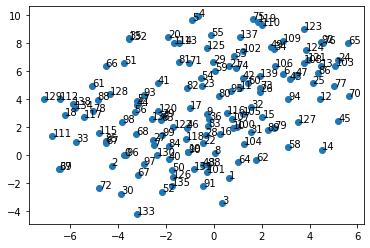

In [173]:

tsne = TSNE(n_components=2, random_state=42)
tsne_points = tsne.fit_transform(embeddings_list)
plt.scatter(tsne_points[:, 0], tsne_points[:, 1])

for label, x, y in zip(eval_df.index.tolist(), tsne_points[:, 0], tsne_points[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


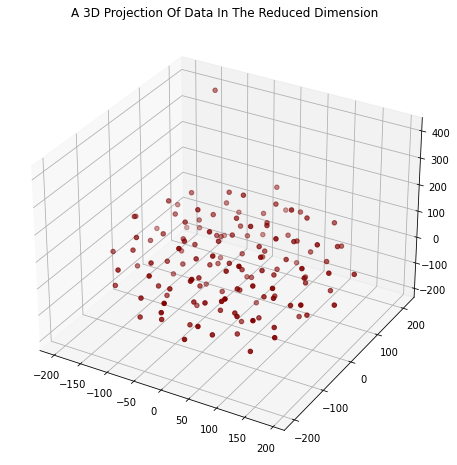

In [172]:
tsne3D = TSNE(n_components=3, random_state=42)
vectors = tsne3D.fit_transform(embeddings_list)
#To plot 
x =vectors[:, 0]
y =vectors[:, 1]
z =vectors[:, 2]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

### Extracting Embeddings with Spacy

In [5]:
import spacy
import spacy_transformers

In [6]:
nlp = spacy.load('en_core_web_lg')

In [9]:
def get_spacy_embeddinngs(text):
    return nlp(text).vector

In [23]:
test_df['embeddings'] = test_df['tweet_text'].apply(get_spacy_embeddinngs)

In [24]:
train_df['embeddings'] = train_df['tweet_text'].apply(get_spacy_embeddinngs)

In [25]:
train_df

,tweet_text,check_worthiness,embeddings
0,Since this will never get reported by the medi...,1,"[-2.1167495, 1.0477401, -2.6801953, 0.2568842,..."
1,"Thanks, MichaelBloomberg. Here’s a handy littl...",0,"[-0.98138785, 0.22638561, -2.039588, 0.1731587..."
2,"Folks, when you say ""The COVID-19 isn't a big ...",0,"[-1.5059841, 1.4505239, -1.4857037, 0.5198375,..."
3,Just 1 case of COVID-19 in India and people ar...,0,"[-0.6662297, -0.075812794, -2.143128, 0.664096..."
4,President made a commitment to donate his sala...,1,"[-1.5378754, 1.4535497, -3.0178602, 0.0856368,..."
...,...,...,...
817,Stop spreading fake news COVID-19,0,"[2.77114, -0.71131, -0.41439193, 1.707914, 3.4..."
818,It's fake! It's fake!' shout residents of a co...,1,"[-0.68415344, 1.0711503, -2.7403574, 0.1158563..."
819,Be Smart about COVID-19: 1⃣ follow accurate pu...,0,"[0.26835325, 0.7363974, -1.7005619, 0.4014599,..."
820,"On the left: , a Qatari puppet, attacks Saudi ...",1,"[-1.6394866, -0.7697975, -0.018549794, 0.42806..."


### Embeddings Representing Key Words

In [72]:
# num_words = None
num_words = 100
vocabulary = dict()
fdist = nltk.FreqDist()

for index, row in train_df.iterrows():
   token_list = str.split(row.tweet_text)
   for word in token_list:
      fdist[word] += 1
      
common_words = fdist.most_common(num_words)

for idx, word in enumerate(common_words):
   vocabulary[word[0]] = (idx+1)

In [73]:
len(vocabulary)

100

In [74]:
embeddings_list = []
word_list = []

In [75]:
for token in vocabulary:
    try:
        embedding = embeddings_dict[token]
        embeddings_list.append(embedding)
        word_list.append(token)
    except:
        continue

In [76]:
len(embeddings_list)

98

In [114]:
len(embeddings_list)

140

In [117]:
len(embeddings_list[0])


768

### Clustering

In [26]:
clustered_df = train_df.copy()

In [27]:
embeddings_list = clustered_df['embeddings'].tolist()
label_list = clustered_df['check_worthiness'].tolist()

c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


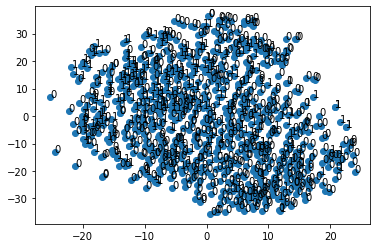

In [30]:
tsne = TSNE(n_components=2, random_state=42)
tsne_points = tsne.fit_transform(embeddings_list)
plt.scatter(tsne_points[:, 0], tsne_points[:, 1])

for label, x, y in zip(label_list, tsne_points[:, 0], tsne_points[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

Estimated no. of clusters: 1
Estimated no. of noise points: 820


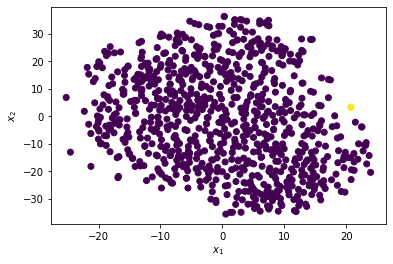

In [47]:
dbscan_cluster = DBSCAN(eps=0.8, min_samples=2)
#dbscan_cluster.fit(tsne_points)
dbscan_cluster.fit(embeddings_list)

# Visualizing DBSCAN
plt.scatter(tsne_points[:, 0], 
tsne_points[:, 1], 
c=dbscan_cluster.labels_, 
label=y)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

# Number of Clusters
cluster_labels=dbscan_cluster.labels_
N_clus=len(set(cluster_labels))-(1 if -1 in cluster_labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(dbscan_cluster.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

# Calculating v_measure
#print('v_measure =', v_measure_score(y, labels))

Text(0, 0.5, '$x_2$')

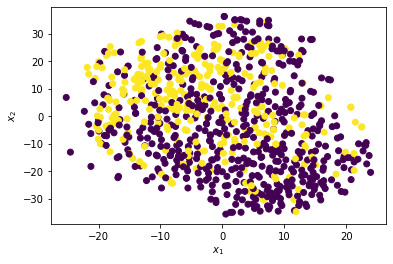

In [35]:
plt.scatter(tsne_points[:, 0], 
tsne_points[:, 1], 
c=label_list, 
label=label_list)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")


In [94]:
eval_df['cluster_labels']= cluster_labels

In [110]:
pd.set_option("display.max_colwidth", 200)
eval_df[['tweet_text', 'check_worthiness', 'cluster_labels']]

,tweet_text,check_worthiness,cluster_labels
0,"POTUS wanted everyone to know he was in close contact with Gaetz and Collins today, both of whom were supposedly exposed to COVID-19. Did he look worried at the presser? No. It’s a message.",1,0
1,Who would you prefer to lead our nation’s response to the growing COVID-19 threat?,0,0
2,It was a really really really really really really really really really really really really really really really really really really really really bad idea to elect Donald Trump President of the...,0,0
3,Bald-faced LIE. did self-quarantine until CDC cleared him to return to work. WuFlu COVID-19 COVID-19,1,0
4,LIVE: Daily media briefing on COVID-19 with COVID-19,0,0
...,...,...,...
135,This is how the COVID-19 is spreading and this is how fast it spreads. We don't have a natural immunity to this virus or a vaccine to protect us. Something as simple as washing your hands can keep...,0,1
136,"Markets are crashing. Tourism is dying. Travel is reduced to almost nothing, And World Financial Systems are in chaos. Because of the COVID-19 scare. And you cannot think Of a single reason Why so...",0,1
137,Pray for Palestine. State of Emergency. - 27 cases of COVID-19 - Major churches and mosques closed - No visitors allowed into Palestine - city of Bethlehem under lockdown - Border and Highways clo...,0,1
138,"ADVISORY TO STUDENTS: Class suspensions were made for your safety. Please use those days to rest, strengthen your immune system, and read your lessons. Please don't gala muna. :)) WalangPasok COVI...",0,1


In [111]:
eval_df.to_excel ('eval_df.xlsx', index = None, header=True)

In [22]:
len(embeddings_list)#[1].shape

140

In [36]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(embeddings_list)
    distortions.append(kmeanModel.inertia_)

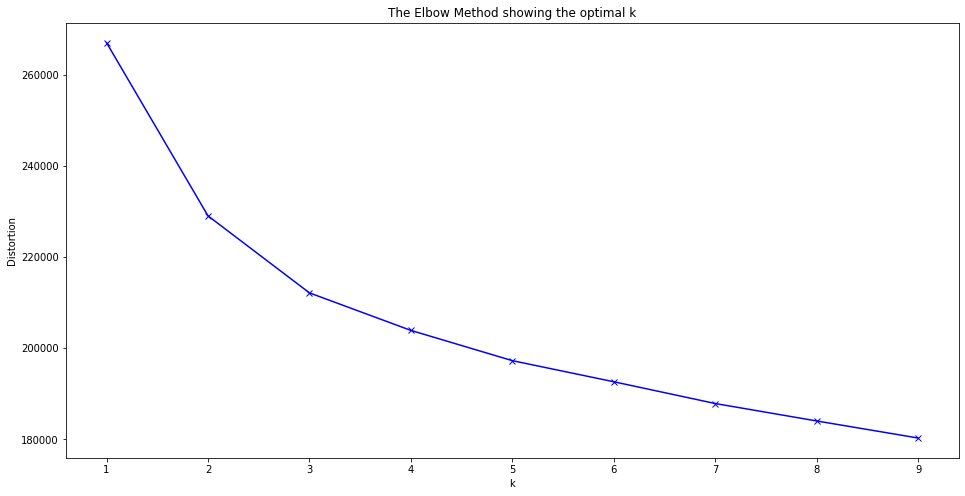

In [37]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [38]:
kmeanModel = KMeans(n_clusters=2)
kmeanModel.fit(embeddings_list)

KMeans(n_clusters=2)

In [58]:
pca = PCA(n_components=2)
PCA_result = pca.fit_transform(embeddings_list)


In [59]:
PCA_result

array([[-9.34745502e-03, -1.03935223e+01],
       [ 4.02283834e+00, -1.12652456e+00],
       [-2.91415934e+00, -2.88915268e+00],
       ...,
       [-6.31906210e-01,  2.96265652e+00],
       [ 1.14399783e+01, -1.60754009e+00],
       [ 9.33060692e+00, -1.75306416e+00]])

In [60]:
cluster_df = pd.DataFrame(PCA_result)

In [61]:
cluster_df

,0,1
0,-0.009347,-10.393522
1,4.022838,-1.126525
2,-2.914159,-2.889153
3,2.748113,3.724904
4,0.690579,-13.269655
...,...,...
817,2.813291,14.127885
818,3.189917,-6.057429
819,-0.631906,2.962657
820,11.439978,-1.607540


In [44]:
cluster_df = pd.DataFrame(tsne_points)

Text(0.5, 1.0, 'K_Means')

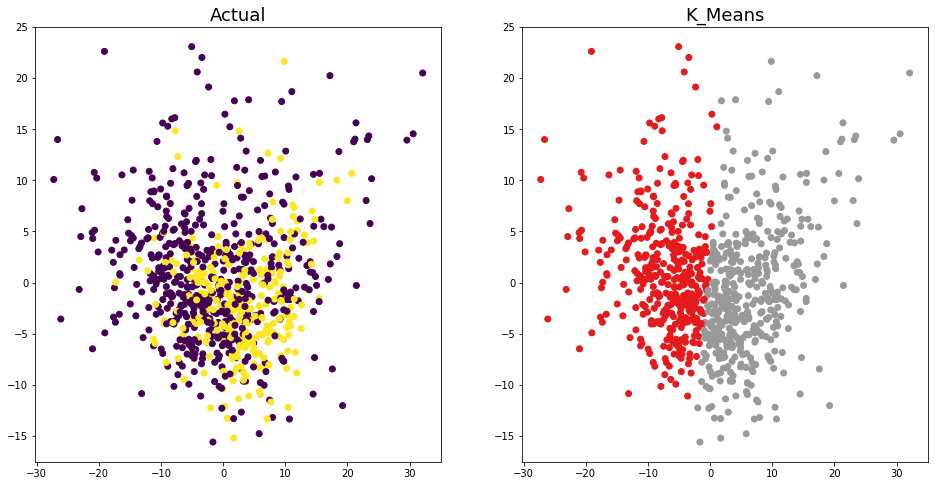

In [62]:
k_means_predictions = kmeanModel.predict(embeddings_list)

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(cluster_df[0], cluster_df[1], c=label_list)
axes[1].scatter(cluster_df[0], cluster_df[1], c=k_means_predictions, cmap=plt.cm.Set1)
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('K_Means', fontsize=18)

In [27]:
clustered_df = train_df.copy()

In [28]:
clustered_df["cluster"] = k_means_predictions

In [109]:
pd.set_option("display.max_colwidth", 200)

In [30]:
clustered_df[clustered_df["cluster"]==0]

,tweet_text,check_worthiness,tweet_embeddings,cluster
1,thanks michaelbloomberg handy little unintentional demo way spread covid clueless person america touch community food much saliva soak finger minimikebloomberg droolingbloomberg,0,"[-0.20052943, -0.026245058, 0.014789059, -0.09561418, -0.06765157, 0.16019005, 0.46522322, -0.1377978, -0.06105624, -0.070732586, -0.08710731, 0.026388884, -0.62646, 0.06759582, 0.038498003, 0.075...",0
2,folk say covid big deal kill disable elderly chornically ill immunocompromised implication people expendable please careful,0,"[-0.07971085, 0.059932012, -0.26377288, 0.071447305, -0.2243096, -0.050948005, 0.39249817, -0.062740155, 0.013031691, 0.095161624, 0.07767839, -0.06994323, -0.5902469, 0.0141440015, -0.090296775, ...",0
3,case covid india people crazy mask daily people die road crash still craze helmetsthinking face safetysaves virus road crash,0,"[0.004987808, -0.014434789, -0.07199488, -0.11981732, 0.08235544, 0.106589995, 0.34812185, -0.21792632, 0.11834013, -0.15663663, 0.11909087, -0.07987656, -0.6438081, -0.17363, 0.033005066, -0.1649...",0
6,dad say cure covid tell remind home movie clip,0,"[0.10187825, 0.20983437, -0.21351524, -0.07337125, 0.002870813, -0.15722726, 0.6540222, 0.22169475, 0.00068124756, -0.12592049, 0.04364457, 0.14507523, -0.5333938, -0.162527, -0.07045419, -0.11668...",0
10,safety always come first panic stay safe coronaalert,0,"[-0.0014817092, -0.08395114, 0.0878213, -0.054689866, 0.081054606, 0.046855576, 0.67777574, 0.12958387, 0.18293987, 0.10071, -0.074199, -0.056715693, -0.9252157, -0.25577715, -0.13975479, -0.15586...",0
...,...,...,...,...
806,covid test us tokyo without state in much europe free worse much us even available unreliable meanwhile potus recently call covid one big hoax usa st world rd world healthcare,1,"[-0.01145949, 0.2561592, 0.00090943754, -0.037081216, 0.043771785, 0.028157072, 0.27454698, -0.009828609, 0.061091103, -0.025058862, 0.10022251, 0.039119642, -0.7116872, 0.033263396, 0.19056228, -...",0
807,still rumor contagious covid period coronavirusoutbreak,0,"[0.1205325, -0.012423001, 0.028881758, -0.049975008, -0.1979595, 0.4346115, 0.673765, 0.21678498, -0.45458996, 0.020137742, -0.07605499, -0.15343624, -0.5173925, -0.23761748, 0.16561826, -0.211160...",0
810,listen interview joe lhota covid fall fakenews find really need know virus spread,0,"[-0.11081946, 0.28534284, -0.051622454, -0.21059741, -0.08904999, -0.047664795, 0.65676177, 0.0026309057, 0.11516754, 0.046070274, 0.048572637, -0.026627727, -0.7115346, -0.2529691, 0.028193533, -...",0
815,come person pass fake steele dossier fbi gotcha hang every word mr corn swear,0,"[-0.019477937, 0.16378823, -0.037042648, -0.037813794, -0.16138384, -0.008980642, 0.4203386, -0.04707993, -0.023390558, 0.14056955, -0.06057864, -0.04295243, -0.3954997, -0.15331769, 0.060189273, ...",0


In [36]:
clustered_df[clustered_df["cluster"]==0].check_worthiness.value_counts()

0    289
1     84
Name: check_worthiness, dtype: int64

In [37]:
clustered_df[clustered_df["cluster"]==1].check_worthiness.value_counts()

0    243
1    206
Name: check_worthiness, dtype: int64

In [74]:
clustered_df

,tweet_text,check_worthiness,tweet_embeddings,cluster
0,"Since this will never get reported by the media, I wanted to share a copy of this check. is once...",1,"[0.109207, 0.13630547, 0.07749088, 0.050894734, -0.014155143, -0.007886097, 0.4836532, 0.0252148...",1
1,"Thanks, MichaelBloomberg. Here’s a handy little (unintentional) demo on the way to spread COVID-...",0,"[-0.021835642, 0.1391446, 0.13693716, 0.051439606, 0.053728245, 0.115537316, 0.38078263, -0.1665...",1
2,"Folks, when you say ""The COVID-19 isn't a big deal, it only kills the disabled, elderly, chornic...",0,"[0.12796694, 0.2493654, 0.040926926, 0.25967494, -0.12869652, 0.16538069, 0.49595913, -0.0268089...",1
3,Just 1 case of COVID-19 in India and people are crazy for masks!! Daily 400 people die in road c...,0,"[-0.04481757, -0.00797525, 0.0077399164, 0.09396254, 0.020197595, 0.1402739, 0.31726393, -0.0759...",1
4,President made a commitment to donate his salary while in office. Honoring that promise and to f...,1,"[0.19193757, 0.0033891278, 0.20370051, 0.14951248, 0.025931433, -0.019666314, 0.49477875, -0.023...",0
...,...,...,...,...
817,Stop spreading fake news COVID-19,0,"[-0.17333, 0.14581867, -0.63697, -0.29653335, -0.176398, -0.50752, 0.46731338, -0.14513, -0.0772...",0
818,It's fake! It's fake!' shout residents of a community in COVID-19 epicenter Wuhan in a viral vid...,1,"[0.0111965, 0.12961009, 0.074181855, 0.04167057, -0.07116068, -0.048524648, 0.231812, -0.1368047...",0
819,Be Smart about COVID-19: 1⃣ follow accurate public health advice and your local health authority...,0,"[0.021628706, 0.09464694, -0.1559374, -0.07817696, -0.026224025, -0.1777546, 0.50399613, -0.0293...",0
820,"On the left: , a Qatari puppet, attacks Saudi Arabia for temporarily disallowing the use of GCC ...",1,"[0.26487496, 0.160397, 0.10070971, 0.089169055, -0.017650386, 0.045907833, 0.24170235, -0.140547...",0


In [ ]:
# fit a 2d PCA model to the vectors

pca = PCA(n_components=2)
PCA_result = pca.fit_transform(train_df['tweet_embeddings'])

# prepare a dataframe
words = pd.DataFrame(words)
PCA_result = pd.DataFrame(PCA_result)
PCA_result['x_values'] =PCA_result.iloc[0:, 0]
PCA_result['y_values'] =PCA_result.iloc[0:, 1]
PCA_final = pd.merge(words, PCA_result, left_index=True, right_index=True)
PCA_final['word'] =PCA_final.iloc[0:, 0]
PCA_data_complet =PCA_final[['word','x_values','y_values']]

In [42]:
train_df['tweet_embeddings'] = train_df['tweet_embeddings'].apply(lambda x: list(x))

,0,1
0,-0.530917,-0.126996
1,-0.395848,0.063602
2,-1.077630,0.068656
3,-0.298845,-0.023537
4,0.039477,-0.191762
...,...,...
817,1.514260,0.000509
818,0.671185,-0.443106
819,0.300740,-0.179432
820,-0.144797,-1.028013


In [ ]:
sns.set_style('ticks')
fig = sns.lmplot(x='x_values', y='y_values',
           data = K_means_data,
           fit_reg=False,
           legend=True,
           hue='Cluster')
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.show()

In [47]:
type(train_df['tweet_embeddings'].values)

numpy.ndarray

In [102]:
sentence = "since never get reported medium want share"

In [103]:
token_list = str.split(sentence)
embedding_list = []
for token in token_list:
    try:
        embedding = embeddings_dict[token]
        embedding_list.append(embedding)
    except:
        continue

In [117]:
embed = embeddings_dict['king']

In [120]:
list(embed)

[-0.31949,
 0.10382,
 0.24294,
 -0.34845,
 -0.23829,
 -0.372,
 0.3795,
 -0.30334,
 -0.21441,
 -0.4923,
 0.098965,
 -0.13791,
 -0.80118,
 0.05041,
 0.039894,
 0.87262,
 0.44222,
 -0.32196,
 0.65187,
 0.1145,
 -0.30635,
 0.13293,
 -0.0068867,
 -0.15688,
 0.19338,
 -0.28577,
 0.2679,
 0.24383,
 0.015909,
 0.076273,
 0.58036,
 -0.071514,
 0.20632,
 -0.309,
 0.30187,
 0.129,
 -0.14297,
 -0.079204,
 0.25754,
 -0.5938,
 -0.001212,
 0.30647,
 0.833,
 -0.054968,
 0.13717,
 -0.11724,
 0.289,
 0.23425,
 0.35452,
 0.13312,
 -0.14014,
 -1.009,
 0.21142,
 0.53368,
 0.13168,
 -0.13271,
 0.25046,
 0.028531,
 -0.64371,
 0.056957,
 -0.49754,
 -0.0071232,
 -0.40831,
 -0.39913,
 -0.5956,
 -0.58436,
 0.085161,
 0.37481,
 0.082033,
 -0.32318,
 0.053241,
 -0.21014,
 -0.65141,
 -0.035154,
 0.3492,
 -0.39234,
 -0.24786,
 0.32653,
 0.21577,
 0.52755,
 0.3151,
 -0.022263,
 0.21523,
 0.67203,
 -1.0397,
 0.43497,
 -0.4411,
 0.2761,
 0.28093,
 -0.22985,
 0.93106,
 -0.066438,
 -0.0036527,
 -0.25866,
 0.37648,
 -0.05

In [119]:
type(embed)

numpy.ndarray

In [115]:
embedding.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [113]:
embedding.reshape(1).shape

ValueError: cannot reshape array of size 200 into shape (1,)

In [105]:
embedding_list.reshape(1,-1)

AttributeError: 'list' object has no attribute 'reshape'

In [106]:
embedding_array = np.array(embedding_list)
embedding_array

array([[ 0.22425  ,  0.10087  , -0.12007  , ...,  0.24304  ,  0.47749  ,
         0.12814  ],
       [-0.28163  ,  0.6649   , -0.065842 , ...,  0.30737  , -0.13003  ,
        -0.35331  ],
       [-0.20837  ,  0.37201  , -0.066035 , ..., -0.0091251, -0.26669  ,
         0.29602  ],
       ...,
       [-1.0611   , -0.20787  ,  0.21119  , ...,  0.47331  ,  0.076635 ,
        -0.44055  ],
       [ 0.31705  ,  0.51477  , -0.26564  , ...,  0.071046 ,  0.32593  ,
        -0.070306 ],
       [-0.26172  ,  0.42376  , -0.29992  , ..., -0.019416 ,  0.41491  ,
         0.26887  ]], dtype=float32)

In [62]:
averaged_array = np.average(embedding_array, axis=0)

In [140]:
averaged_array.shape[0]

200

In [58]:
type(embedding_matrix[0])

numpy.ndarray